# Analysis of neighborhoods in San Francisco - Where to open a pizza place?

## Introduction 

San Francisco is one of the booming cities in US and one of the main tourists attractions. Each district of San Francisco carries its own unique and distinct culture. Thus it's quite hard for a new business to become successful and compete with already established restaurnts of various cusines and pizza being one of the main food in the US it's even harder for a new small pizza place to become successful. But if it is possible to anaylize the neighborhoods in San Francisco to find area where there is not much competition and high demand it'll be really useful for a newcomer to be successful. 

## Data Used for Analysis

The dataset "San Francisco Neighborhoods as ZIP Codes" from San Francisco Burden of Disease & Injury Study is used to gain information of neighborhoods and the district they belong along with the zip code. The latitude and longitude of each neighborhood is obtaine using pgeocode python library. The foursquare api is used to gain information on popular venues in the above neighborhoods.

## Web Scraping and Data Clensing

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from geopy.geocoders import Nominatim
! pip install --user folium
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors


     |████████████████████████████████| 102kB 9.4MB/s ta 0:00:011


In [2]:
#Getting the webdata
url = 'http://www.healthysf.org/bdi/outcomes/zipmap.htm'
dfs = pd.read_html(url, header=0)
df = dfs[3]
df.head()

,Zip Code,Neighborhood,Population (Census 2000)
0,94102,Hayes Valley/Tenderloin/North of Market,28991
1,94103,South of Market,23016
2,94107,Potrero Hill,17368
3,94108,Chinatown,13716
4,94109,Polk/Russian Hill (Nob Hill),56322


In [3]:
#dropping missing values, if exists
df.dropna().head()

,Zip Code,Neighborhood,Population (Census 2000)
0,94102,Hayes Valley/Tenderloin/North of Market,28991
1,94103,South of Market,23016
2,94107,Potrero Hill,17368
3,94108,Chinatown,13716
4,94109,Polk/Russian Hill (Nob Hill),56322


In [4]:
#drop the last row containing the sum of each column
df.drop([21], inplace=True)

In [5]:
df.shape

(21, 3)

In [6]:
df.rename(columns = {'Population (Census 2000)':'Population', 'Zip Code':'Postal Code'}, inplace=True)

In [7]:
df.head()

,Postal Code,Neighborhood,Population
0,94102,Hayes Valley/Tenderloin/North of Market,28991
1,94103,South of Market,23016
2,94107,Potrero Hill,17368
3,94108,Chinatown,13716
4,94109,Polk/Russian Hill (Nob Hill),56322


In [8]:
! pip install --user pgeocode

In [9]:
#Obatining the latitude and logitude data using pgeocode

In [10]:
import pgeocode

In [11]:
nomi = pgeocode.Nominatim('us')

In [12]:
#obtaining the geo data for each postal code
df_2 = nomi.query_postal_code(df['Postal Code'].to_list())

In [13]:
df_2.shape
df_2.head()

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,94102,US,San Francisco,California,CA,City and County of San Francisco,75.0,NaN,NaN,37.7813,-122.4167,4.0
1,94103,US,San Francisco,California,CA,City and County of San Francisco,75.0,NaN,NaN,37.7725,-122.4147,4.0
2,94107,US,San Francisco,California,CA,City and County of San Francisco,75.0,NaN,NaN,37.7621,-122.3971,4.0
3,94108,US,San Francisco,California,CA,City and County of San Francisco,75.0,NaN,NaN,37.7929,-122.4079,4.0
4,94109,US,San Francisco,California,CA,City and County of San Francisco,75.0,NaN,NaN,37.7917,-122.4186,4.0


In [14]:
df_2 = df_2.drop(['country code', 'place_name', 'state_name', 'state_code', 'county_name', 'county_code', 'community_name', 'community_code', 'accuracy'], axis = 1)

In [15]:
df_2.rename(columns = {'postal_code':'Postal Code'}, inplace=True)

In [16]:
df_2.head()

,Postal Code,latitude,longitude
0,94102,37.7813,-122.4167
1,94103,37.7725,-122.4147
2,94107,37.7621,-122.3971
3,94108,37.7929,-122.4079
4,94109,37.7917,-122.4186


In [17]:
#Combining the two dataframes
df_new = df.merge(df_2, how='inner', left_on='Postal Code', right_on='Postal Code')

In [18]:
df_new.head()

,Postal Code,Neighborhood,Population,latitude,longitude
0,94102,Hayes Valley/Tenderloin/North of Market,28991,37.7813,-122.4167
1,94103,South of Market,23016,37.7725,-122.4147
2,94107,Potrero Hill,17368,37.7621,-122.3971
3,94108,Chinatown,13716,37.7929,-122.4079
4,94109,Polk/Russian Hill (Nob Hill),56322,37.7917,-122.4186


## Neighborhood Exploring and Clustering

In [19]:
#Foursquare Credentials
CLIENT_ID = 'VOVAKA2MXQHC5LUGHLZJFEUYWSHCCXPOCCQ5BMMFQVZFIGZO' 
CLIENT_SECRET = '4CLILCWQKA2BEZXI2QTSL3DPA3T2XOWMM3BW2J5LG0S05J2C' 
VERSION = '20180605' 

In [20]:
#function to explore all the neighborhoods 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
import requests
#Getting popular venues in neighbirhoods 
SF_venues = getNearbyVenues(names=df_new['Neighborhood'],
                                   latitudes=df_new['latitude'],
                                   longitudes=df_new['longitude']
                                  )

Hayes Valley/Tenderloin/North of Market
South of Market
Potrero Hill
Chinatown
Polk/Russian Hill (Nob Hill)
Inner Mission/Bernal Heights
Ingelside-Excelsior/Crocker-Amazon
Castro/Noe Valley
Western Addition/Japantown
Parkside/Forest Hill
Haight-Ashbury
Inner Richmond
Outer Richmond
Sunset
Marina
Bayview-Hunters Point
St. Francis Wood/Miraloma/West Portal
Twin Peaks-Glen Park
Lake Merced
North Beach/Chinatown
Visitacion Valley/Sunnydale


In [22]:
SF_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.7813,-122.4167,Asian Art Museum,37.780178,-122.416505,Art Museum
1,Hayes Valley/Tenderloin/North of Market,37.7813,-122.4167,Ales Unlimited: Beer Basement,37.782751,-122.415656,Beer Bar
2,Hayes Valley/Tenderloin/North of Market,37.7813,-122.4167,Philz Coffee,37.781433,-122.417073,Coffee Shop
3,Hayes Valley/Tenderloin/North of Market,37.7813,-122.4167,George and Lennie,37.781701,-122.415213,Coffee Shop
4,Hayes Valley/Tenderloin/North of Market,37.7813,-122.4167,Saigon Sandwich,37.783084,-122.417650,Sandwich Place


In [23]:
#Filtering pizza places, bakeries and Italian resaturants
SF_pizza_venues = SF_venues[(SF_venues['Venue Category'] == 'Pizza Place') | (SF_venues['Venue Category'] == 'Bakery') | (SF_venues['Venue Category'] == 'Italian Restaurant')]
SF_pizza_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
36,South of Market,37.7725,-122.4147,The Cake Gallery,37.773997,-122.411882,Bakery
72,Potrero Hill,37.7621,-122.3971,Goat Hill Pizza,37.762434,-122.397654,Pizza Place
108,Chinatown,37.7929,-122.4079,The AA Bakery & Cafe,37.795720,-122.408286,Bakery
117,Chinatown,37.7929,-122.4079,Del Popolo,37.789807,-122.411347,Pizza Place
134,Polk/Russian Hill (Nob Hill),37.7917,-122.4186,Lotta's Bakery,37.792765,-122.421098,Bakery
173,Inner Mission/Bernal Heights,37.7509,-122.4153,Dianda's Italian American Pastry,37.750921,-122.418328,Bakery
180,Ingelside-Excelsior/Crocker-Amazon,37.7195,-122.4411,Little Joe's Pizza,37.718478,-122.439856,Pizza Place
183,Ingelside-Excelsior/Crocker-Amazon,37.7195,-122.4411,Bravo's Pizza,37.716590,-122.440974,Pizza Place
197,Ingelside-Excelsior/Crocker-Amazon,37.7195,-122.4411,Little Caesars Pizza,37.716062,-122.440091,Pizza Place
242,Western Addition/Japantown,37.7856,-122.4358,Jane the Bakery,37.783797,-122.434283,Bakery


In [24]:
#Count the number of places that serves pizza in each neighborhood
df_pizza_count = SF_pizza_venues[["Neighborhood","Venue Category"]]
df_pizza_count = df_pizza_count.groupby('Neighborhood').count()

In [25]:
df_pizza_count.reset_index(level=0, inplace=True)

In [26]:
#create a new dataframe containing the number of pizza places
df_pizza_count.rename(columns={'Venue Category':'Pizza Place Count'}, inplace = True)

In [27]:
df_pizza_count.shape

(15, 2)

In [28]:
df_final = df.merge(df_pizza_count, how='outer', left_on='Neighborhood', right_on='Neighborhood')

In [29]:
#filling missing values in number of pizza places column with 0
df_final.fillna(0, inplace=True)

In [30]:
df_final.drop(['Postal Code'], axis = 1, inplace = True)

In [31]:
#add a column containing the ratio between number pizza places and population
df_final['num/pop'] = (df_final['Pizza Place Count']/df_final['Population']) * 1000


In [32]:
df_final

,Neighborhood,Population,Pizza Place Count,num/pop
0,Hayes Valley/Tenderloin/North of Market,28991,0.0,0.000000
1,South of Market,23016,1.0,0.043448
2,Potrero Hill,17368,1.0,0.057577
3,Chinatown,13716,2.0,0.145815
4,Polk/Russian Hill (Nob Hill),56322,1.0,0.017755
5,Inner Mission/Bernal Heights,74633,1.0,0.013399
6,Ingelside-Excelsior/Crocker-Amazon,73104,3.0,0.041037
7,Castro/Noe Valley,30574,0.0,0.000000
8,Western Addition/Japantown,33115,5.0,0.150989
9,Parkside/Forest Hill,42958,2.0,0.046557


In [33]:
#dataframe for clustering
df_clus = df_final.drop(['Population', 'Pizza Place Count'], axis = 1)

In [34]:
df_clus.head()

,Neighborhood,num/pop
0,Hayes Valley/Tenderloin/North of Market,0.000000
1,South of Market,0.043448
2,Potrero Hill,0.057577
3,Chinatown,0.145815
4,Polk/Russian Hill (Nob Hill),0.017755


## Clustering neighborhoods according to the population and most popular venues

In [35]:
from sklearn.cluster import KMeans

In [36]:
#finding the optimum k for clustering using elbow method
accuracy = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_clus.drop('Neighborhood', axis = 1))
    accuracy.append(kmeanModel.inertia_)

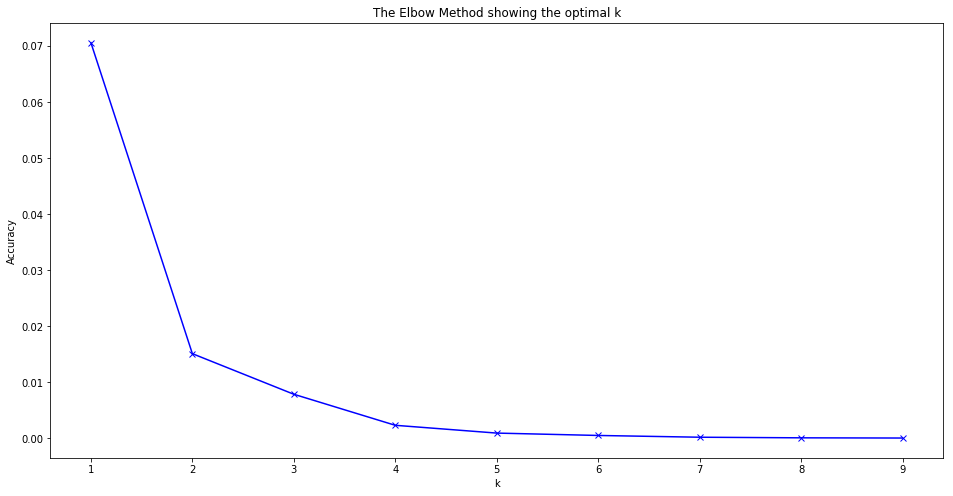

In [37]:
plt.figure(figsize=(16,8))
plt.plot(K, accuracy, 'bx-')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As shown in the accuracy vs k plot above, we can state that according to the elbow method k=4 is the optimum solution.

In [38]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(df_clus.drop('Neighborhood', axis = 1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [39]:
kmeanModel.labels_[0:10] 

array([2, 0, 0, 1, 2, 2, 0, 2, 1, 0], dtype=int32)

In [40]:
#Insert the cluster labels to the dataframe
df_final.insert(0, 'Cluster Labels', kmeanModel.labels_)

In [41]:
df_final

,Cluster Labels,Neighborhood,Population,Pizza Place Count,num/pop
0,2,Hayes Valley/Tenderloin/North of Market,28991,0.0,0.000000
1,0,South of Market,23016,1.0,0.043448
2,0,Potrero Hill,17368,1.0,0.057577
3,1,Chinatown,13716,2.0,0.145815
4,2,Polk/Russian Hill (Nob Hill),56322,1.0,0.017755
5,2,Inner Mission/Bernal Heights,74633,1.0,0.013399
6,0,Ingelside-Excelsior/Crocker-Amazon,73104,3.0,0.041037
7,2,Castro/Noe Valley,30574,0.0,0.000000
8,1,Western Addition/Japantown,33115,5.0,0.150989
9,0,Parkside/Forest Hill,42958,2.0,0.046557


In [42]:
#Inserting Location data
df_with_co = df_final.merge(df_new, how='inner', left_on='Neighborhood', right_on='Neighborhood')

In [43]:
df_with_co.head()

,Cluster Labels,Neighborhood,Population_x,Pizza Place Count,num/pop,Postal Code,Population_y,latitude,longitude
0,2,Hayes Valley/Tenderloin/North of Market,28991,0.0,0.000000,94102,28991,37.7813,-122.4167
1,0,South of Market,23016,1.0,0.043448,94103,23016,37.7725,-122.4147
2,0,Potrero Hill,17368,1.0,0.057577,94107,17368,37.7621,-122.3971
3,1,Chinatown,13716,2.0,0.145815,94108,13716,37.7929,-122.4079
4,2,Polk/Russian Hill (Nob Hill),56322,1.0,0.017755,94109,56322,37.7917,-122.4186


In [44]:
df_with_co.drop('Population_y', axis=1, inplace=True)


In [45]:
df_with_co.rename(columns={'Population_x':'Population'}, inplace = True)

In [46]:
df_with_co.head()

,Cluster Labels,Neighborhood,Population,Pizza Place Count,num/pop,Postal Code,latitude,longitude
0,2,Hayes Valley/Tenderloin/North of Market,28991,0.0,0.000000,94102,37.7813,-122.4167
1,0,South of Market,23016,1.0,0.043448,94103,37.7725,-122.4147
2,0,Potrero Hill,17368,1.0,0.057577,94107,37.7621,-122.3971
3,1,Chinatown,13716,2.0,0.145815,94108,37.7929,-122.4079
4,2,Polk/Russian Hill (Nob Hill),56322,1.0,0.017755,94109,37.7917,-122.4186


## Visualization

In [47]:
from geopy.geocoders import Nominatim

#getting geo data of Sanfrancisco
address = 'San Francisco, US'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

k = 4
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_with_co['latitude'], df_with_co['longitude'], df_with_co['Neighborhood'], df_with_co['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [48]:
res = df_with_co.groupby('Cluster Labels')

In [49]:
#exploring each cluster
res.get_group(0)

,Cluster Labels,Neighborhood,Population,Pizza Place Count,num/pop,Postal Code,latitude,longitude
1,0,South of Market,23016,1.0,0.043448,94103,37.7725,-122.4147
2,0,Potrero Hill,17368,1.0,0.057577,94107,37.7621,-122.3971
6,0,Ingelside-Excelsior/Crocker-Amazon,73104,3.0,0.041037,94112,37.7195,-122.4411
9,0,Parkside/Forest Hill,42958,2.0,0.046557,94116,37.7441,-122.4863
10,0,Haight-Ashbury,38738,2.0,0.051629,94117,37.7712,-122.4413
12,0,Outer Richmond,42473,2.0,0.047089,94121,37.7786,-122.4892
13,0,Sunset,55492,2.0,0.036041,94122,37.7593,-122.4836
15,0,Bayview-Hunters Point,33170,1.0,0.030148,94124,37.7309,-122.3886
18,0,Lake Merced,26291,1.0,0.038036,94132,37.7211,-122.4754


In [50]:
res.get_group(1)

,Cluster Labels,Neighborhood,Population,Pizza Place Count,num/pop,Postal Code,latitude,longitude
3,1,Chinatown,13716,2.0,0.145815,94108,37.7929,-122.4079
8,1,Western Addition/Japantown,33115,5.0,0.150989,94115,37.7856,-122.4358
11,1,Inner Richmond,38939,4.0,0.102725,94118,37.7812,-122.4614


In [51]:
res.get_group(2)

,Cluster Labels,Neighborhood,Population,Pizza Place Count,num/pop,Postal Code,latitude,longitude
0,2,Hayes Valley/Tenderloin/North of Market,28991,0.0,0.000000,94102,37.7813,-122.4167
4,2,Polk/Russian Hill (Nob Hill),56322,1.0,0.017755,94109,37.7917,-122.4186
5,2,Inner Mission/Bernal Heights,74633,1.0,0.013399,94110,37.7509,-122.4153
7,2,Castro/Noe Valley,30574,0.0,0.000000,94114,37.7587,-122.4330
14,2,Marina,22903,0.0,0.000000,94123,37.7999,-122.4342
16,2,St. Francis Wood/Miraloma/West Portal,20624,0.0,0.000000,94127,37.7354,-122.4571
17,2,Twin Peaks-Glen Park,27897,0.0,0.000000,94131,37.7450,-122.4383
20,2,Visitacion Valley/Sunnydale,40134,0.0,0.000000,94134,37.7190,-122.4096


In [52]:
res.get_group(3)

,Cluster Labels,Neighborhood,Population,Pizza Place Count,num/pop,Postal Code,latitude,longitude
19,3,North Beach/Chinatown,26827,6.0,0.223655,94133,37.8002,-122.4091
